# Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data processing
from sklearn.preprocessing import LabelEncoder

# NLP
import string
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import nltk.corpus
from nltk.stem import WordNetLemmatizer

# EDA
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Word Cloud
from wordcloud import WordCloud

# Data preparation
from sklearn.model_selection import train_test_split

# Model Building
# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

# Deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, SpatialDropout1D, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Dataset
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Download: [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data)

**Download dataset**

In [2]:
df = pd.read_csv('/content/Amazon Fine Food Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


# Data Preprocessing

**Reduce size of dataset**

because using a whole dataset consumes a lot of time for training a model

In [4]:
# Assume df is your original DataFrame with 500,000 rows
df = df.sample(n=100000, random_state=42)  # Randomly selects 100,000 rows

# Reset the index (optional)
df = df.reset_index(drop=True)

# Check the new DataFrame size
print(df.shape)  # Output: (100000, columns)

(100000, 10)


**Concatenate Text and Summary Columns**

In [5]:
df["reviews"] = df["Text"] + " " + df["Summary"]
df.drop(columns = ["Text", "Summary"], axis = 1, inplace = True)

**Check missing values**

In [6]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,3
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
reviews,9


**Drop missing values**

In [7]:
df.dropna(subset=['Score', 'reviews'], inplace=True)

**Precentage of Score**

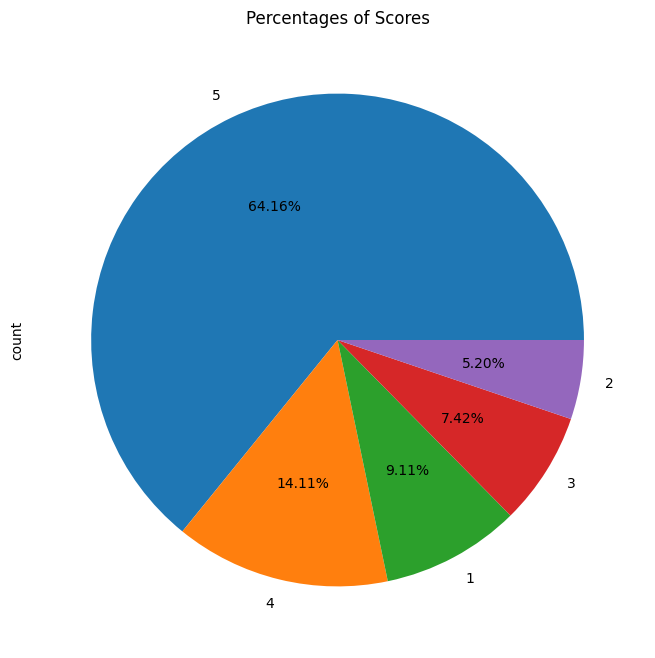

In [8]:
df.Score.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of Scores", loc = "center")
plt.show()

**Classify Score into 3 Categories**

In [9]:
def Classify(Rows):
  if(Rows["Score"] > 3.0):
    Label = "Positive"
  elif(Rows["Score"] < 3.0):
    Label = "Negative"
  elif(Rows["Score"] == 3.0):
    Label = "Neutral"

  return Label

df["sentiment"] = df.apply(Classify, axis = 1)

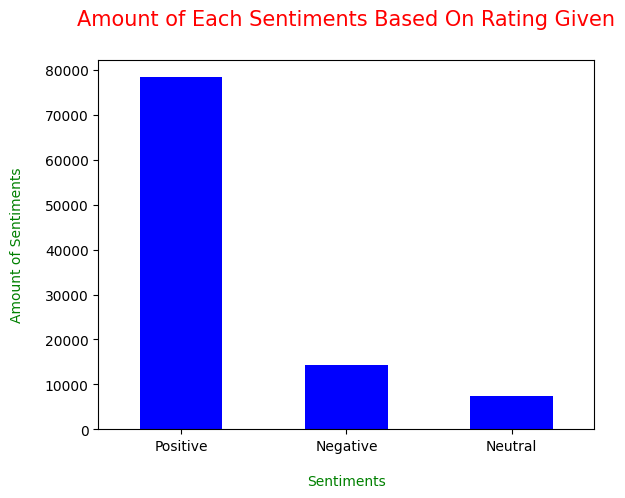

In [10]:
df["sentiment"].value_counts().plot(kind = "bar", color = "blue")
plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xlabel("Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.show()

## Feature Engineer
**Drop insignificant columns**

In [11]:
columns = ["Id", "ProductId", "UserId", "ProfileName", "HelpfulnessNumerator", "HelpfulnessDenominator", "Time", "Score"]
df.drop(columns=columns, axis=1, inplace=True)

**Encoding target variables**

In [12]:
Encoder = LabelEncoder()
df['sentiment'] = Encoder.fit_transform(df['sentiment'])

# Save the label mapping for later
label_mapping = dict(zip(Encoder.classes_, Encoder.transform(Encoder.classes_)))
print(label_mapping)

{'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}


In [13]:
df.head()

,reviews,sentiment
0,Having tried a couple of other brands of glute...,2
1,My cat loves these treats. If ever I can't fin...,2
2,A little less than I expected. It tends to ha...,1
3,"First there was Frosted Mini-Wheats, in origin...",0
4,and I want to congratulate the graphic artist ...,2


## Text Preprocessing
**Removing irrelevant information**

In [14]:
def Text_Cleaning(Text):
  # Remove possible links
  Text = re.sub('<a href="https?://\S+">', '', Text)
  Text = re.sub('<br />|</a>', '', Text)

  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

**Text processing**

In [15]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)


  for word in Tokens:
    if word not in Stopwords: # Stop-word removal
      Processed_Text.append(Lemmatizer.lemmatize(word)) # Lemmatization

  return(" ".join(Processed_Text))

In [16]:
df["reviews"] = df["reviews"].apply(lambda Text: Text_Cleaning(Text))
df["reviews"] = df["reviews"].apply(lambda Text: Text_Processing(Text))

# Exploratory Data Analysis
**Overview**

In [17]:
df.head()

,reviews,sentiment
0,tried couple brand gluten free sandwich cooky ...,2
1,cat love treat ever find house pop top bolt wh...,2
2,little less expected tends muddy taste not exp...,1
3,first frosted mini wheat original size frosted...,0
4,want congratulate graphic artist putting entir...,2


In [18]:
polarity = df["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

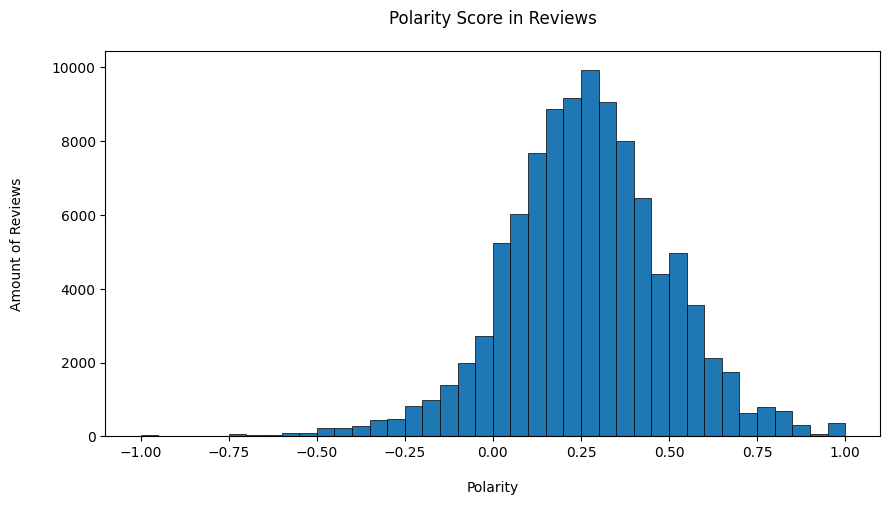

In [19]:
polarity.plot(kind = "hist", bins = 40, edgecolor = "black", linewidth = 0.5, figsize = (10,5))
plt.title("Polarity Score in Reviews", pad = 20)
plt.xlabel("Polarity", labelpad = 15)
plt.ylabel("Amount of Reviews", labelpad = 20)

plt.show()

In [20]:
length = df["reviews"].astype(str).apply(len)

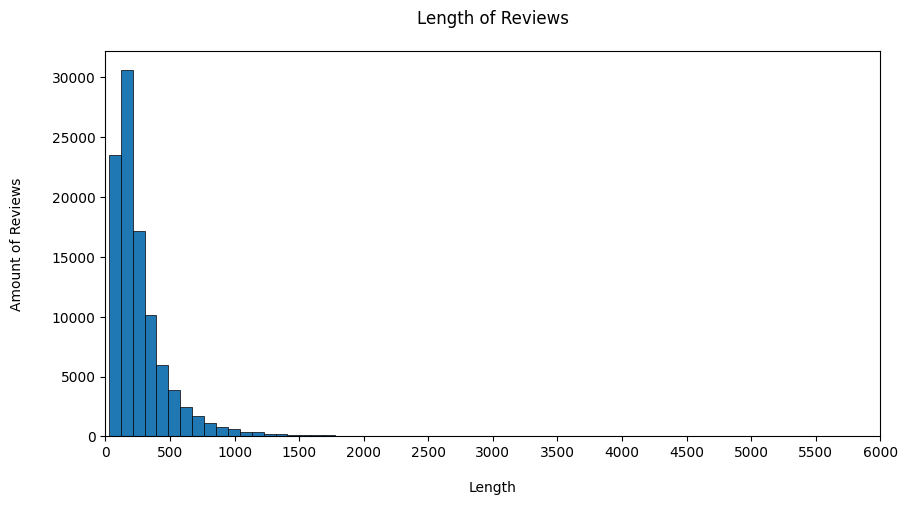

In [21]:
length.plot(kind = "hist", bins = 80, edgecolor = "black", linewidth = 0.5, figsize = (10,5))
plt.title("Length of Reviews", pad = 20)
plt.xlabel("Length", labelpad = 15)
plt.ylabel("Amount of Reviews", labelpad = 20)
plt.xlim(0, 6001)
plt.xticks(np.arange(0, 6001, 500))

plt.show()

In [22]:
word_counts = df["reviews"].apply(lambda x: len(str(x).split()))

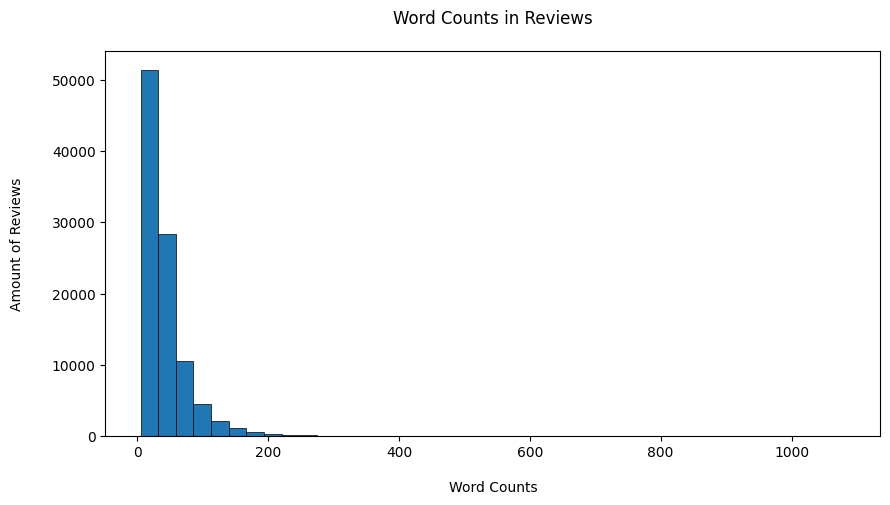

In [23]:
word_counts.plot(kind = "hist", bins = 40, edgecolor = "black", linewidth = 0.5, figsize = (10,5))
plt.title("Word Counts in Reviews", pad = 20)
plt.xlabel("Word Counts", labelpad = 15)
plt.ylabel("Amount of Reviews", labelpad = 20)

plt.show()

# N-Gram Analysis

**Define N-Gram Function**

In [24]:
# Stopwords need to be a list instead of set
Stopwords = list(Stopwords)

def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  # Convert a collection of text documents to a matrix of token counts.
  Vectorizer = CountVectorizer(stop_words = Stopwords, ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = []
  for word, idx in Vectorizer.vocabulary_.items():
    words.append((word, Count[0, idx]))

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

**Filter The DataFrame Based On Sentiments**

In [25]:
positive = df[df["sentiment"] == 2]
neutral = df[df["sentiment"] == 1]
negative = df[df["sentiment"] == 0]

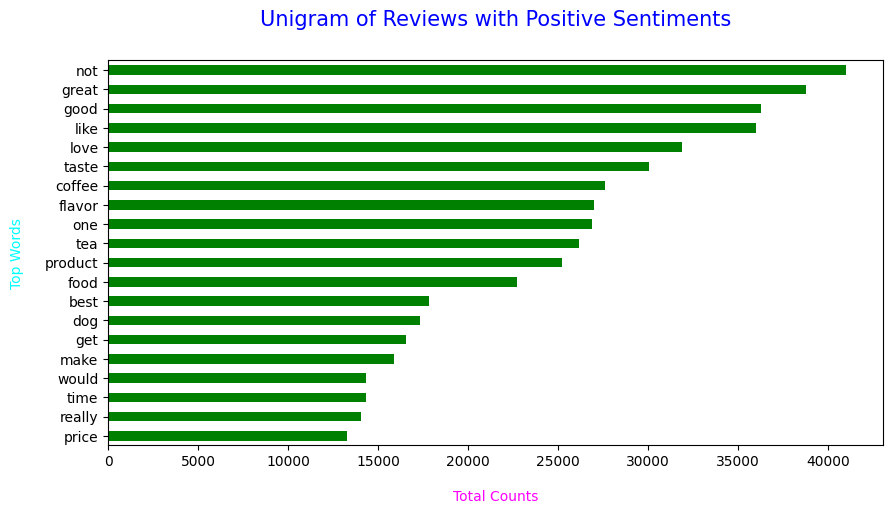

In [26]:
# Finding Unigram
words = Gram_Analysis(positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

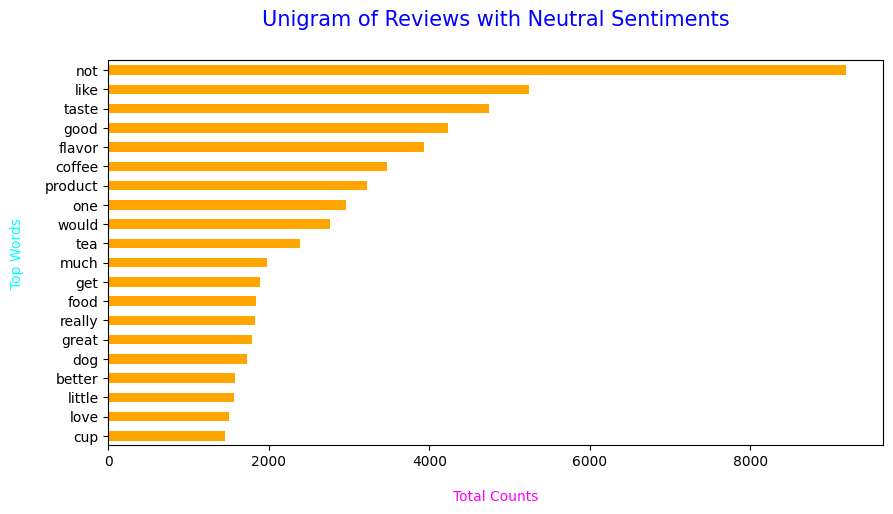

In [27]:
# Finding Unigram
words = Gram_Analysis(neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

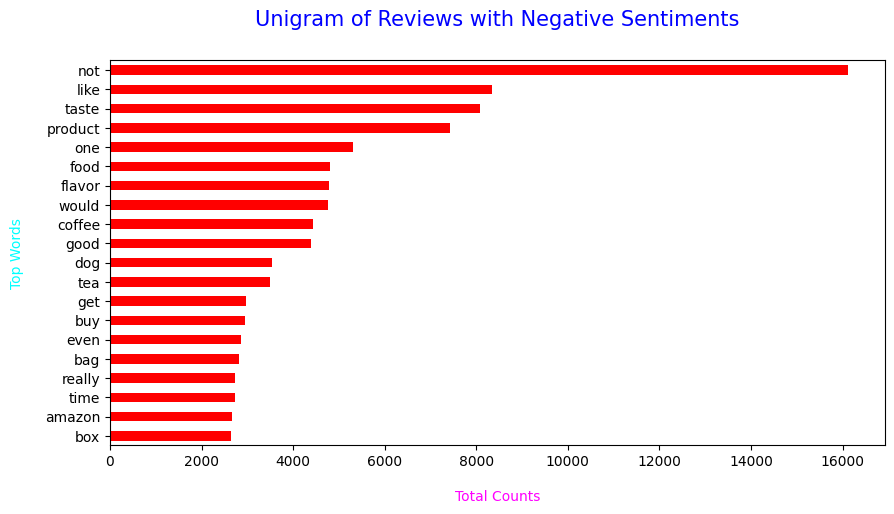

In [28]:
# Finding Unigram
words = Gram_Analysis(negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

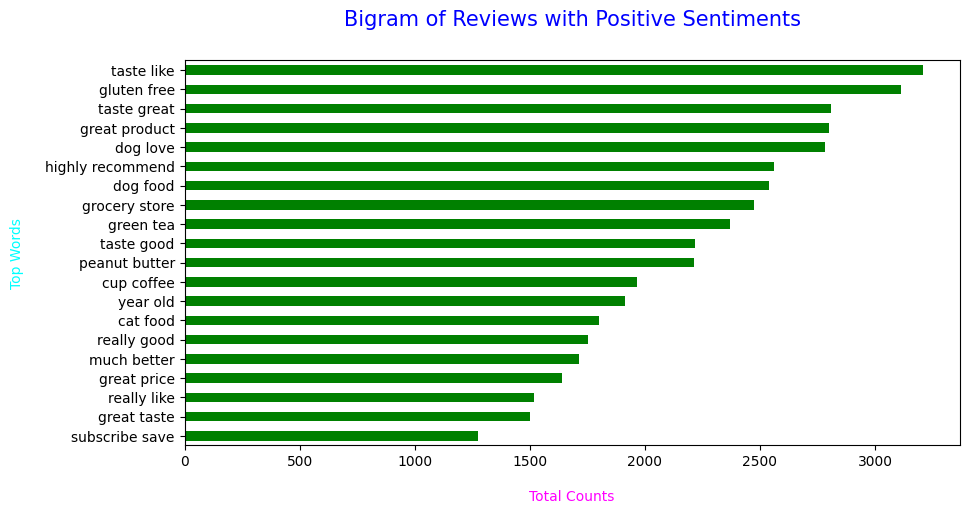

In [29]:
# Finding Bigram
words = Gram_Analysis(positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

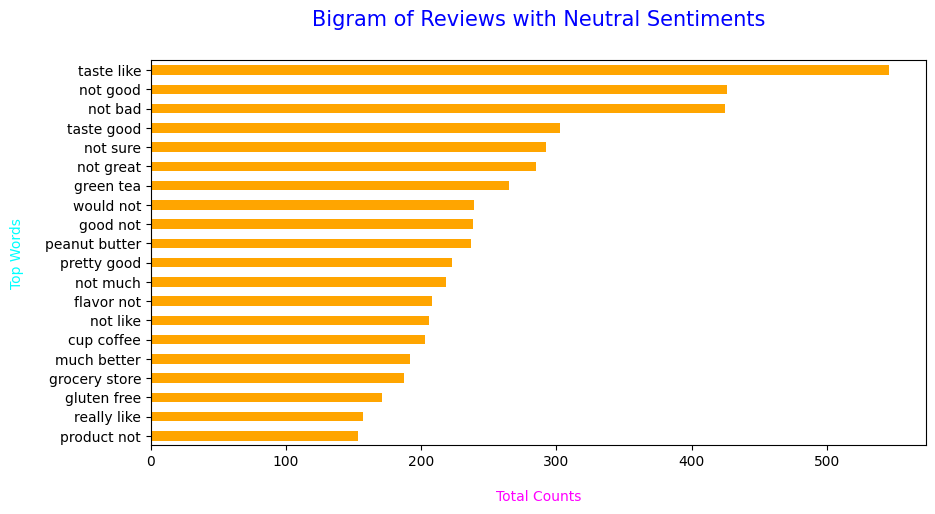

In [30]:
# Finding Bigram
words = Gram_Analysis(neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

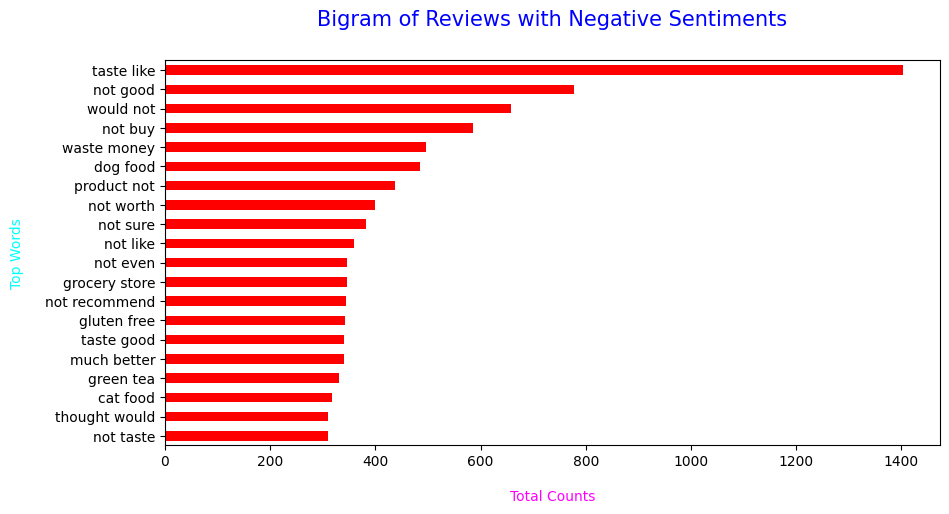

In [31]:
# Finding Bigram
words = Gram_Analysis(negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

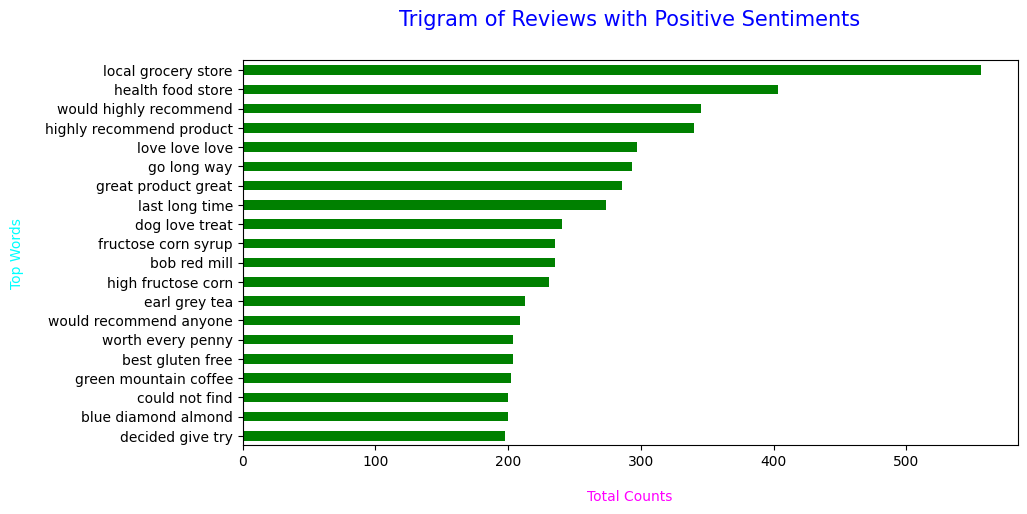

In [32]:
# Finding Trigram
words = Gram_Analysis(positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

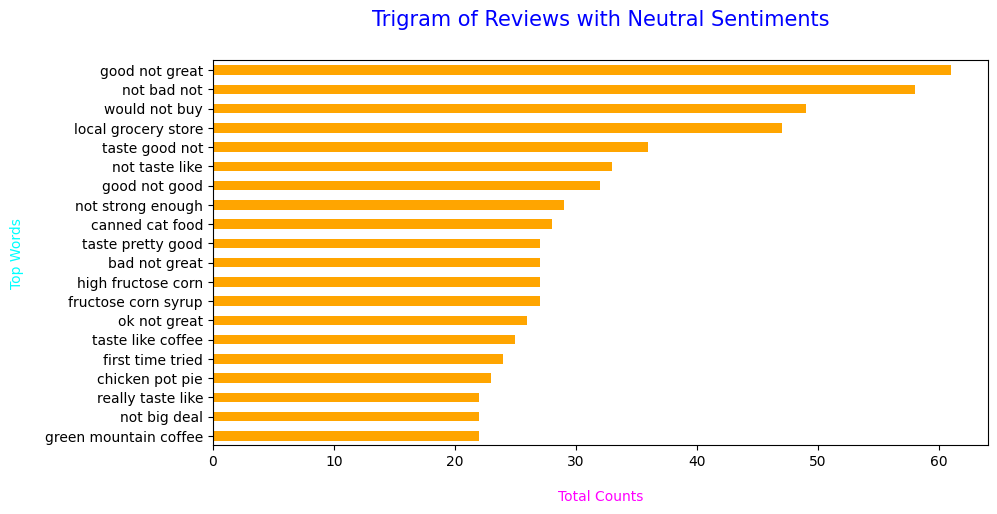

In [33]:
# Finding Trigram
words = Gram_Analysis(neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

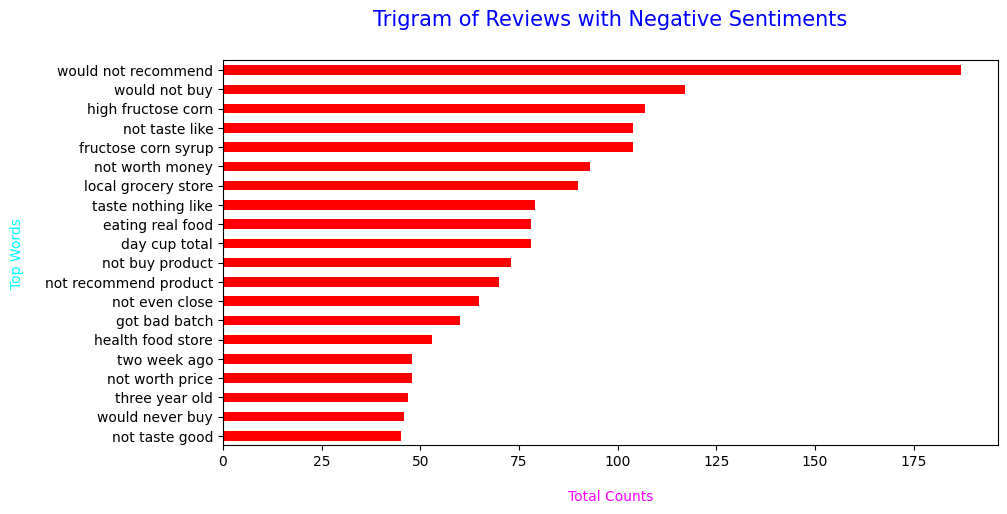

In [34]:
# Finding Trigram
words = Gram_Analysis(negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

# Word Clouds
The WordCloud function is used to visualize the most frequently occurring words in a given text. Words that appear more frequently are shown larger, while less frequent words appear smaller. It can quickly identify key themes in text data

****Word Cloud with Positive Sentiments****

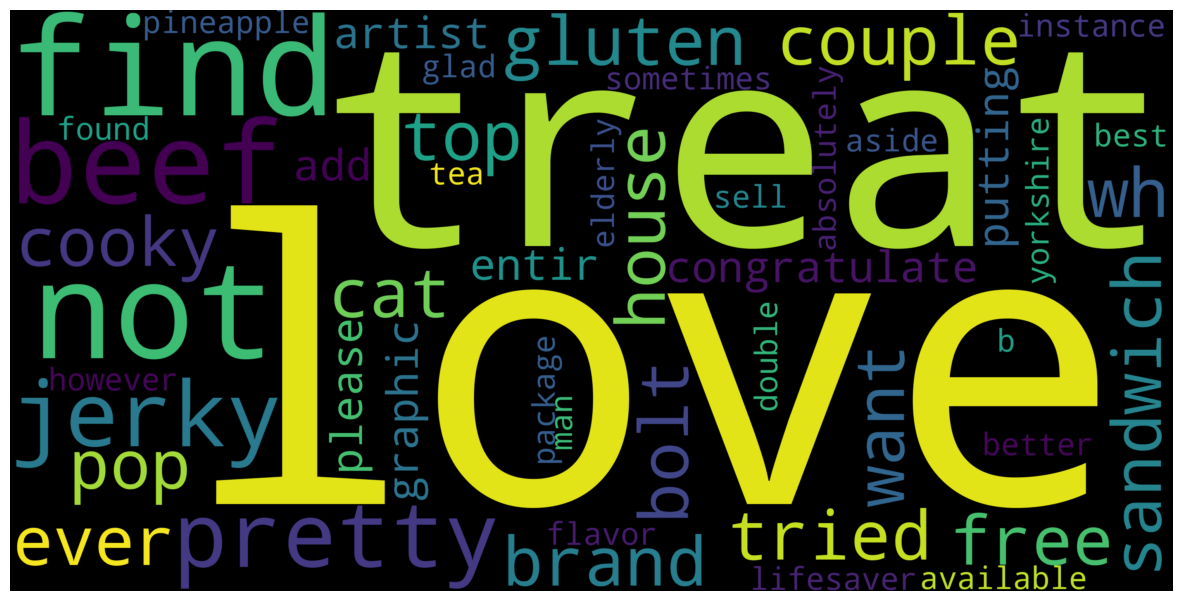

In [35]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(positive["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

**Word Cloud with Neutral Sentiments**

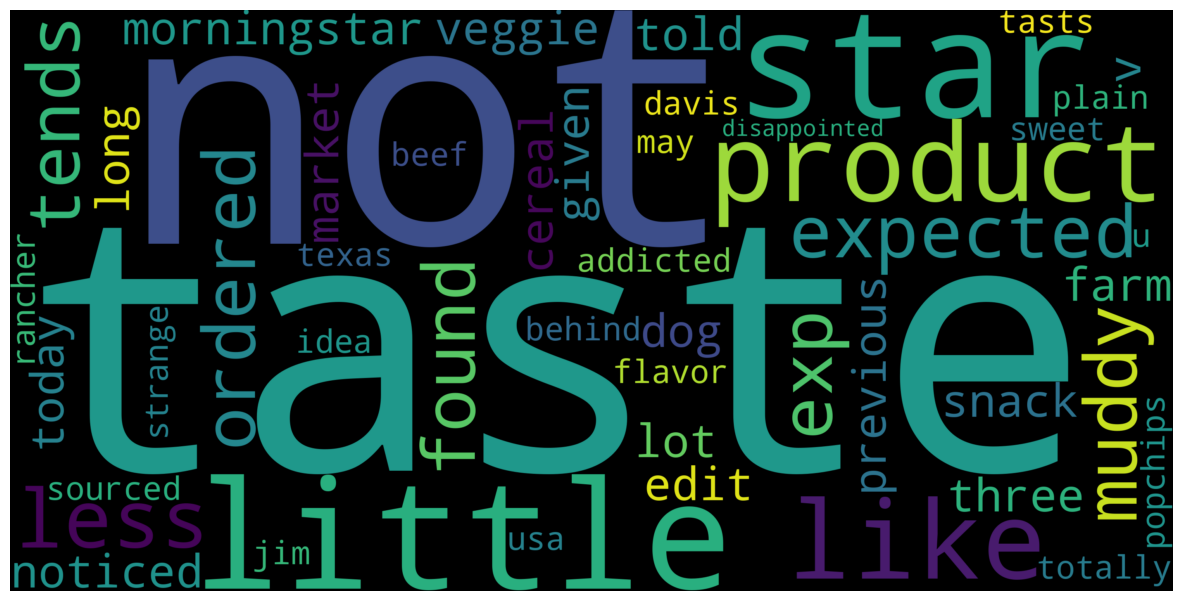

In [36]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(neutral["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

**Word Cloud with Negative Sentiments**

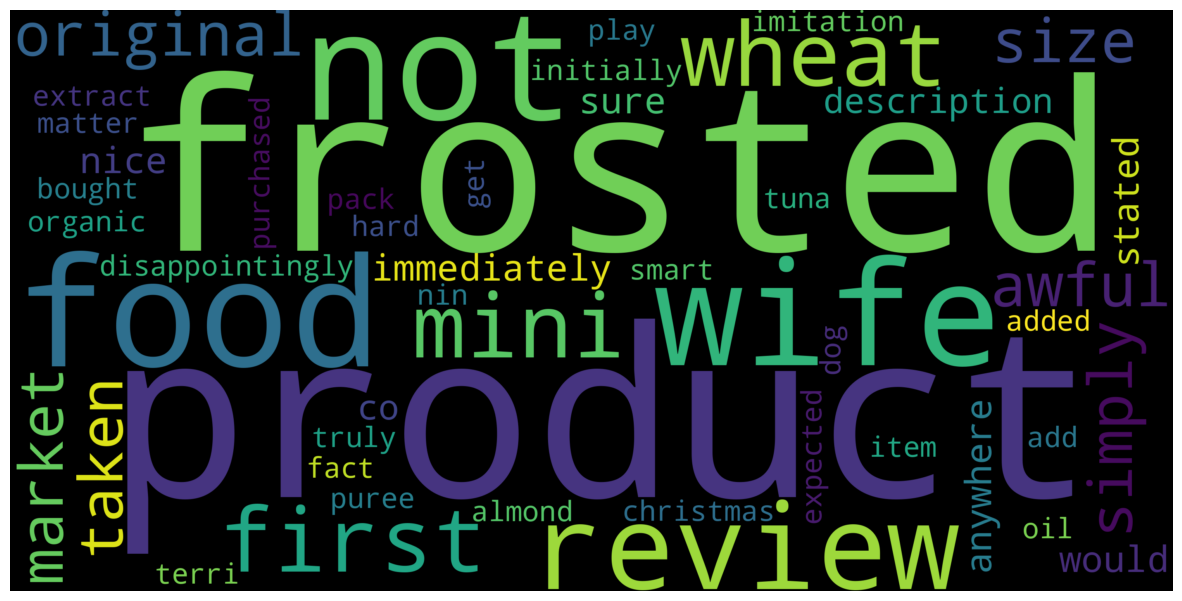

In [37]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(negative["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# Machine learning model

In [38]:
df['sentiment'].value_counts()

,count
sentiment,
2,78263
0,14307
1,7421


## Data preparation
**TF-IDF Vectorizer**

In [ ]:
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(df["reviews"])
y = df["sentiment"]

# Check our matrix shape
X.shape

(99991, 5000)

**Split Dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training and Evaluation

In [ ]:
# rule-based approach
# Machine learning
DT = DecisionTreeClassifier()
LG = LogisticRegression()
RF = RandomForestClassifier()
NB = BernoulliNB()
KNN = KNeighborsClassifier()

ML_models = [DT, LG, RF, NB, KNN]
models_dic = {0:"Decision Tree", 1:"Logistic Regression", 2:"Random Forest", 3:"Bernoulli Naive Bayes", 4:"KNeighbors"}

for i, model in enumerate(ML_models):
  print("{} Test Accuracy: {}".format(models_dic[i], cross_val_score(model, X, y, cv = 5, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.8094128648826681
Logistic Regression Test Accuracy: 0.84237582466182
Random Forest Test Accuracy: 0.8452960856863726
Bernoulli Naive Bayes Test Accuracy: 0.8131432309189217
KNeighbors Test Accuracy: 0.7468471943449158


**Hyperparameter Tuning**

In [ ]:
# Define a reduced parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RF, param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_accuracy = random_search.best_score_
best_parameters = random_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Accuracy: 82.72 %
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}


# Deep learning model

## Data preparation

In [39]:
# Tokenizer
tokenizer = Tokenizer(num_words = 5000, split=' ')
tokenizer.fit_on_texts(df['reviews'].values)
X = tokenizer.texts_to_sequences(df['reviews'].values)
X = pad_sequences(X)
y = df['sentiment']
y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training and Evaluation

In [40]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)

In [41]:
model.fit(X_train, y_train, epochs = 12, batch_size=32)

Epoch 1/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 152s 57ms/step - accuracy: 0.8482 - loss: 0.4241
Epoch 2/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 198s 58ms/step - accuracy: 0.8953 - loss: 0.2810
Epoch 3/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 202s 58ms/step - accuracy: 0.9156 - loss: 0.2300
Epoch 4/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 201s 57ms/step - accuracy: 0.9290 - loss: 0.1939
Epoch 5/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 202s 57ms/step - accuracy: 0.9440 - loss: 0.1598
Epoch 6/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 203s 58ms/step - accuracy: 0.9568 - loss: 0.1269
Epoch 7/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 201s 57ms/step - accuracy: 0.9679 - loss: 0.0957
Epoch 8/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 202s 57ms/step - accuracy: 0.9740 - loss: 0.0783
Epoch 9/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 202s 58ms/step - accuracy: 0.9803 - loss: 0.0606
Epoch 10/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 144s 58ms/step - accuracy: 0.9855 - loss: 0.0450
Epoch 11/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 145s 58ms/step - accuracy: 0.9881 - loss: 0.03

In [42]:
# Evaluate model on test data
score = model.evaluate(X_test, y_test)

# Calculate precision, recall, F1 score
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print('Precision:', precision_score(y_test_argmax, y_pred, average='weighted'))
print('Recall:', recall_score(y_test_argmax, y_pred, average='weighted'))
print('F1 score:', f1_score(y_test_argmax, y_pred, average='weighted'))

625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.8823 - loss: 0.6163
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step
Precision: 0.8748225828645743
Recall: 0.8822941147057353
F1 score: 0.8780458341419002
